## Importing the packages

In [6]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

## Importing the Dataset

In [7]:
df = pd.read_csv('Fraud_transaction.csv')

In [8]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [9]:
df.shape

(14247, 11)

## Overview of the Data

In [10]:
def missing_info(column, df):

    '''
        Utility Function to compute the missing value info
        of any feature in a dataset.
    '''

    na = df[column].isna()
    count = na.sum()
    total_count = df.shape[0]
    miss_prcnt = np.round((count/total_count)*100,3)

    return (count, miss_prcnt)

In [11]:
def missing_train_info(df):
    '''
        Utility Function to get information about missing values in the dataframe,
        for each column the following information is given by this function.

            - Number of missing values present in the column.
            - Percentage of missing values in the column.
    '''

    columns_missing_info = []

    for column in df:

        count, miss_prcnt = missing_info(column, df);

        if(count):
            columns_missing_info.append([column, count, miss_prcnt])

    column_names = ['Feature_Name', 'Missing_Count', 'Missing_Percentage']

    missing_info_df = pd.DataFrame(data = columns_missing_info, columns = column_names)

    return missing_info_df

In [12]:
missing_train_df = missing_train_info(df)

In [13]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [14]:
missing_train_df.head(df.shape[1])

,Feature_Name,Missing_Count,Missing_Percentage
0,oldbalanceOrg,1,0.007
1,newbalanceOrig,1,0.007
2,nameDest,1,0.007
3,oldbalanceDest,1,0.007
4,newbalanceDest,1,0.007
5,isFraud,1,0.007
6,isFlaggedFraud,1,0.007


## Exploratory Data Analysis

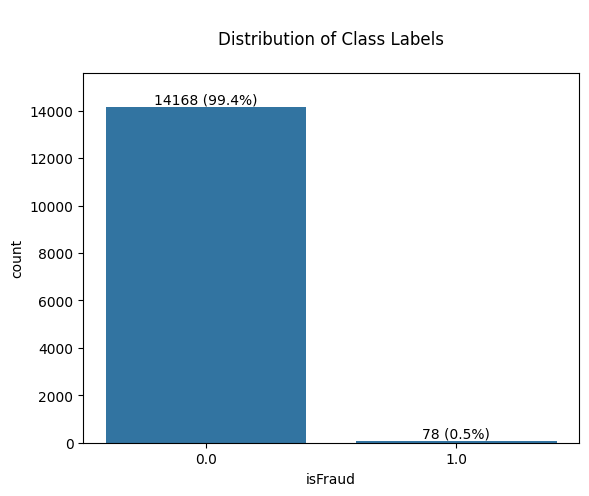

In [15]:
ax = sns.countplot(x='isFraud', data = df)

plt.title("\nDistribution of Class Labels\n")

plt.margins(0.05, 0.1)

for p in ax.patches:
  x=p.get_bbox().get_points()[:,0]
  y=p.get_bbox().get_points()[1,1]
  ax.annotate('{} ({:.1f}%)'.format(int(y),100.*y/len(df)), (x.mean(), y),
          ha='center', va='bottom')

plt.show()

> This shows that the dataset is highly imbalanced

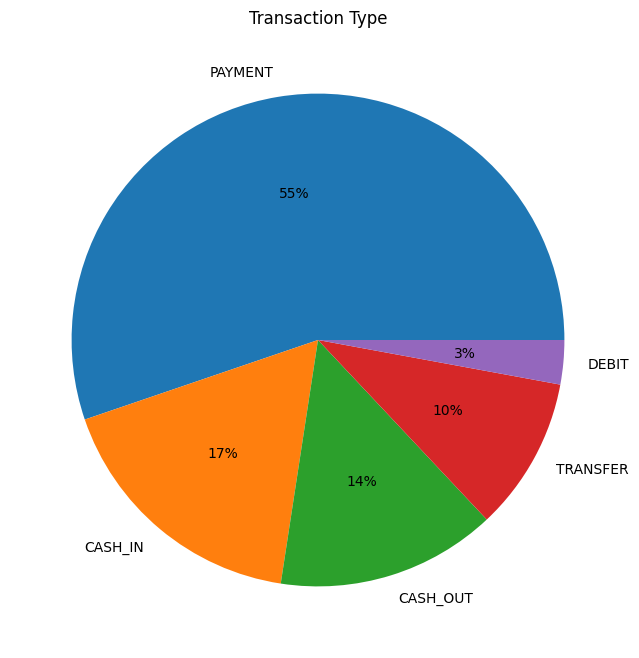

In [16]:
plt.figure(figsize=(10,8))
plt.pie(df.type.value_counts().values,labels=df.type.value_counts().index,  autopct='%.0f%%')
plt.title("Transaction Type")
plt.show()

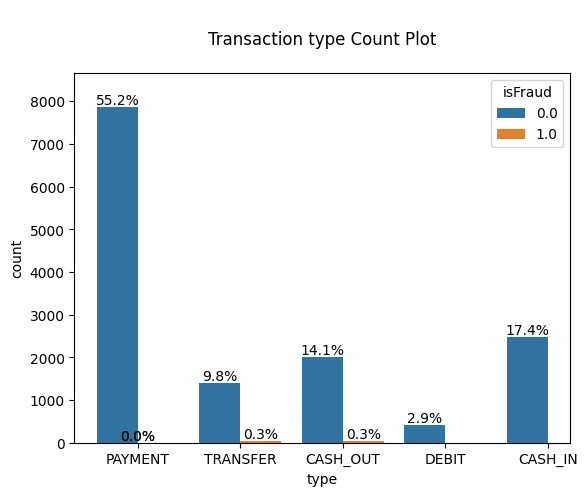

In [17]:
ax = sns.countplot(x='type', hue='isFraud', data = df)

plt.margins(0.05, 0.1)

for p in ax.patches:
  x=p.get_bbox().get_points()[:,0]
  y=p.get_bbox().get_points()[1,1]
  ax.annotate('{:.1f}%'.format(100.*y/len(df)), (x.mean(), y),
          ha='center', va='bottom')

plt.title('\nTransaction type Count Plot\n')
plt.show()

In [18]:
fraud_size=df[df['isFraud'].isin([1])].groupby(['type']).size()
fraud_size

,0
type,
CASH_OUT,40
TRANSFER,38


> PAYMENT, DEBIT and CASH_IN has no fraudulent transaction

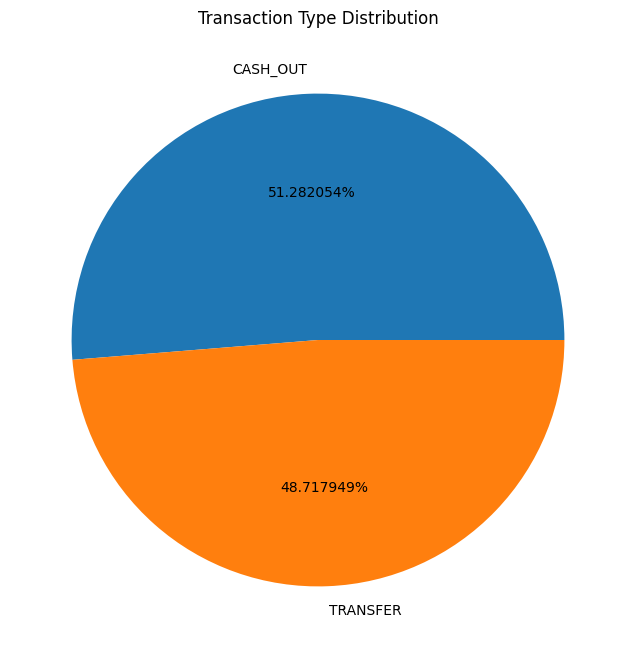

In [19]:
plt.figure(figsize=(10,8))
plt.pie(fraud_size.values,labels=fraud_size.index, autopct='%.6f%%')
plt.title("Transaction Type Distribution")
plt.show()

In [20]:
transfer_fraud = df[((df['type']=='TRANSFER') & df['isFraud']==1)]
transfer_fraud['nameOrig'].value_counts()

,count
nameOrig,
C1305486145,1
C1420196421,1
C137533655,1
C1334405552,1
C1364127192,1
C669700766,1
C1872047468,1
C1093223281,1
C1440057381,1


In [21]:
cash_out_fraud = df[(df['type'] == 'CASH_OUT') & (df['isFraud'] == 1)]
cash_out_fraud['nameDest'].value_counts()

,count
nameDest,
C38997010,1
C1007251739,1
C339924917,1
C667346055,1
C716083600,1
C1983025922,1
C1364913072,1
C297927961,1
C2100440237,1


In [22]:
fraud_trans = df[df['isFraud'] == 1]
valid_trans = df[df['isFraud'] == 0]

trans_transfer = df[df['type'] == 'TRANSER']
trans_cashout = df[df['type'] == 'CASH_OUT']

print('Has the receiving account used for cashing out?')
trans_transfer.nameDest.isin(trans_cashout.nameOrig).any()

Has the receiving account used for cashing out?


False

In [23]:
df_temp = df[df.isFlaggedFraud==1]
print("How many frauds transactions are Flagged?:")
print(len(df_temp))

# Check if df_temp is empty before proceeding
if df_temp.empty:
    print("No fraud transactions are flagged.")
else:
    print("What type of transactions are they?")
    print(df_temp['type'].value_counts().index[0])
    print("Are all these flagged also marked as Fraud Transactions?")
    print(df_temp['isFraud'].value_counts()[1] == len(df_temp))

How many frauds transactions are Flagged?:
0
No fraud transactions are flagged.


In [24]:
df[['amount']].describe()

,amount
count,1.424700e+04
mean,1.118848e+05
std,2.805152e+05
min,2.390000e+00
25%,4.585130e+03
50%,1.286936e+04
75%,1.218917e+05
max,1.000000e+07


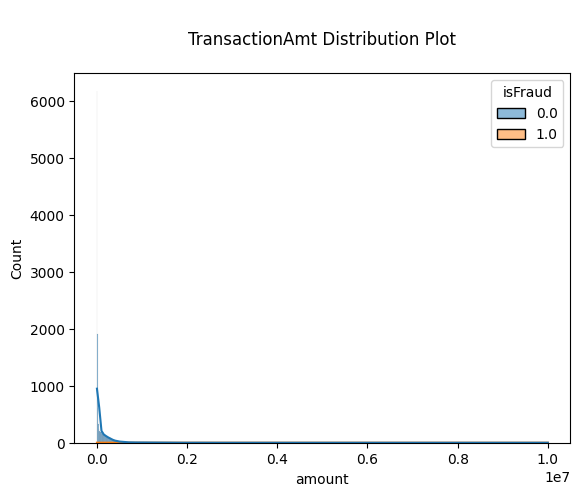

In [25]:
sns.histplot(x='amount', hue='isFraud', data=df, kde=True)
plt.title('\nTransactionAmt Distribution Plot\n')
plt.show()

In [26]:
def check_corr(lst):
  '''
    Utility Function to check Correlation between features.
  '''
  df_corr= df[lst].corr()
  plt.figure(figsize= (25,15))
  sns.heatmap(df_corr,annot= True)
  plt.show()

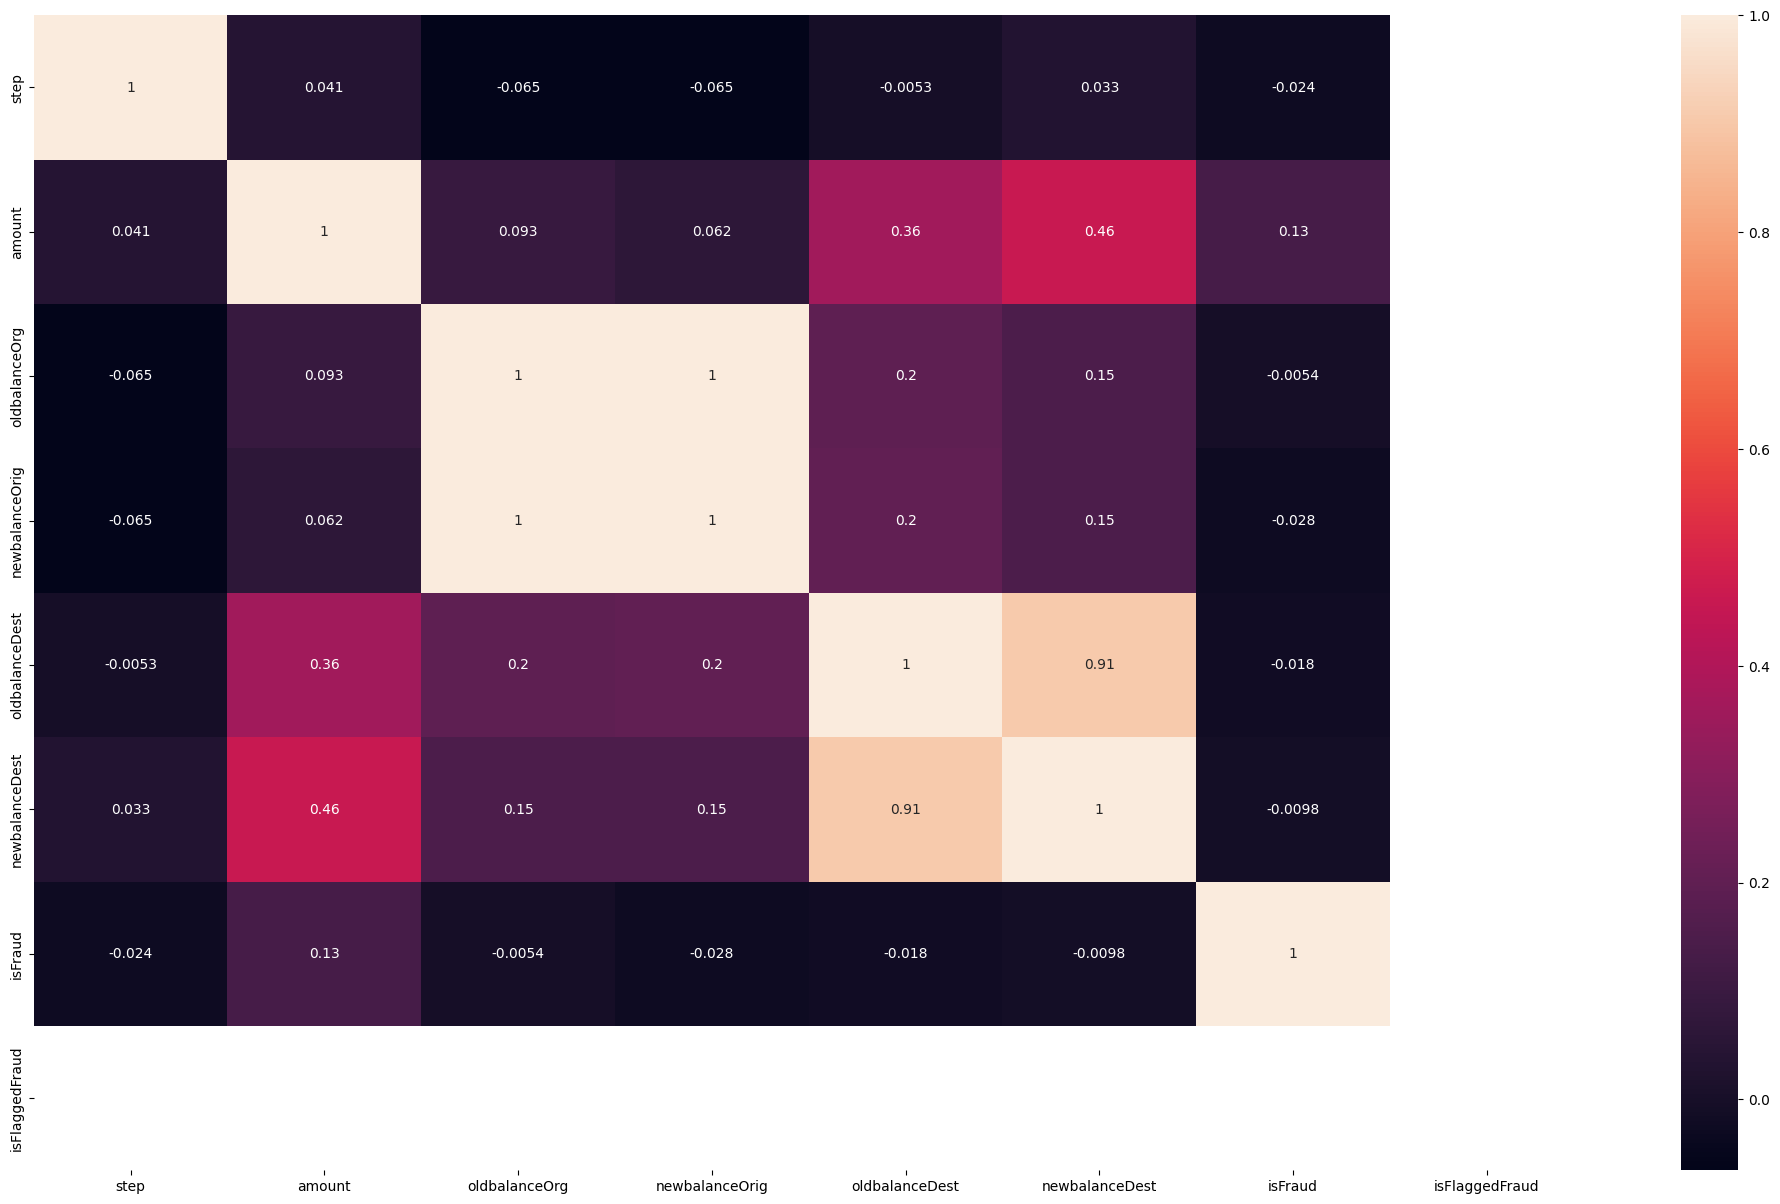

In [27]:
check_corr(['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud'])

In [28]:
def label_encode(df, catf):

  '''
    Utility Function to Encode Categorical Features.
  '''

  for f in catf:

    df[f] = df[f].astype(str)

    le = LabelEncoder()
    le.fit(df[f])
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    df[f] = le.transform(df[f])


  return (df)

In [29]:
data = df.copy()

In [30]:
catf = ['type','nameOrig','nameDest']

In [31]:
data = label_encode(data,catf)

## Baseline Performance

#### Hyperparameter Tuning

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Handle missing values in 'isFraud' column before splitting
data['isFraud'] = data['isFraud'].fillna(data['isFraud'].mode()[0])  # Fill with mode

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['isFraud', 'isFlaggedFraud'], axis=1),
    data['isFraud'],
    test_size=0.3,
    random_state=42,
    stratify=data['isFraud']
)

In [33]:
def hyperparam_vs_auc(train_roc_auc, cv_roc_auc):

    '''
        Utility Function to plot the Training and Cross Validation ROC-AUC Values
        for different Hyperparameter.
    '''

    plt.plot(range(len(train_roc_auc)), train_roc_auc, label='Train AUC')
    plt.plot(range(len(cv_roc_auc)), cv_roc_auc, label='CV AUC')

    plt.scatter(range(len(train_roc_auc)), train_roc_auc, label='Train AUC points')
    plt.scatter(range(len(cv_roc_auc)), cv_roc_auc, label='CV AUC points')

    plt.xticks(range(len(train_roc_auc)))
    plt.legend()
    plt.xlabel("Hyperparameter Index")
    plt.ylabel("AUC")
    plt.title("\n Hyperparameter vs ROC-AUC \n")
    plt.grid()
    plt.show()

In [34]:
learning_rate = [2e-2, 3e-1, 1e-1]
max_depth = [8, 12, 16]
subsample = [0.6,0.8,1]
colsample_bytree = [0.6,0.8,1]

In [35]:
results = {}

dtrain = xgb.DMatrix(X_train, label=y_train)

for rate in learning_rate:
  for depth in max_depth:
    for sample in subsample:
      for colsample in colsample_bytree:

        params = {
          'objective' : 'binary:logistic',
          'eval_metric' : 'auc',
          'learning_rate' : rate,
          'max_depth' : depth,
          'subsample' : sample,
          'colsample_bytree' : colsample,
          'tree_method' : 'gpu_hist',
          'random_state' : 3,
        }

        history = xgb.cv(
            params,
            dtrain,
            num_boost_round = 3000,
            nfold = 3,
            metrics ='auc',
            early_stopping_rounds = 100,
            verbose_eval=100,
            seed=3,
            shuffle = False
        )

        name = "learning_rate : "+str(rate)+" max_depth : "+str(depth)+" subsample : "+str(sample)+" colsample_bytree : "+str(colsample)
        results[name] = (history.iloc[-1]['train-auc-mean'],history.iloc[-1]['test-auc-mean'])

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	train-auc:0.67164+0.08714	test-auc:0.67388+0.10278
[100]	train-auc:0.99915+0.00063	test-auc:0.99036+0.00826
[200]	train-auc:0.99990+0.00001	test-auc:0.99621+0.00247
[300]	train-auc:0.99998+0.00001	test-auc:0.99712+0.00182
[400]	train-auc:0.99999+0.00001	test-auc:0.99761+0.00149
[500]	train-auc:0.99999+0.00001	test-auc:0.99754+0.00171
[549]	train-auc:1.00000+0.00000	test-auc:0.99758+0.00167
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99868+0.00144	test-auc:0.98997+0.01013
[200]	train-auc:0.99992+0.00002	test-auc:0.99695+0.00186
[300]	train-auc:0.99998+0.00001	test-auc:0.99745+0.00150
[400]	train-auc:0.99999+0.00001	test-auc:0.99776+0.00132
[500]	train-auc:1.00000+0.00000	test-auc:0.99778+0.00133
[555]	train-auc:1.00000+0.00000	test-auc:0.99775+0.00137
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99916+0.00070	test-auc:0.99258+0.00483
[200]	train-auc:0.99993+0.00003	test-auc:0.99659+0.00140
[300]	train-auc:0.99998+0.00001	test-auc:0.99720+0.00117
[400]	train-auc:0.99999+0.00001	test-auc:0.99769+0.00115
[500]	train-auc:1.00000+0.00000	test-auc:0.99789+0.00117
[600]	train-auc:1.00000+0.00000	test-auc:0.99792+0.00120
[686]	train-auc:1.00000+0.00000	test-auc:0.99786+0.00129
[0]	train-auc:0.91302+0.07895	test-auc:0.85897+0.10048


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99967+0.00018	test-auc:0.99473+0.00391
[200]	train-auc:0.99998+0.00001	test-auc:0.99710+0.00195
[300]	train-auc:1.00000+0.00000	test-auc:0.99768+0.00154
[400]	train-auc:1.00000+0.00000	test-auc:0.99776+0.00150
[448]	train-auc:1.00000+0.00000	test-auc:0.99780+0.00144
[0]	train-auc:0.92839+0.08020	test-auc:0.88157+0.09996


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99971+0.00019	test-auc:0.99562+0.00315
[200]	train-auc:0.99998+0.00001	test-auc:0.99717+0.00191
[300]	train-auc:1.00000+0.00000	test-auc:0.99786+0.00128
[400]	train-auc:1.00000+0.00000	test-auc:0.99800+0.00118
[488]	train-auc:1.00000+0.00000	test-auc:0.99799+0.00121
[0]	train-auc:0.91742+0.07329	test-auc:0.86823+0.08990


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99939+0.00060	test-auc:0.99473+0.00355
[200]	train-auc:0.99997+0.00001	test-auc:0.99690+0.00182
[300]	train-auc:1.00000+0.00000	test-auc:0.99758+0.00137
[400]	train-auc:1.00000+0.00000	test-auc:0.99777+0.00132
[500]	train-auc:1.00000+0.00000	test-auc:0.99784+0.00132
[576]	train-auc:1.00000+0.00000	test-auc:0.99785+0.00133
[0]	train-auc:0.80075+0.09091	test-auc:0.78690+0.09378


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99976+0.00019	test-auc:0.99517+0.00328
[200]	train-auc:1.00000+0.00000	test-auc:0.99706+0.00227
[300]	train-auc:1.00000+0.00000	test-auc:0.99740+0.00195
[400]	train-auc:1.00000+0.00000	test-auc:0.99740+0.00199
[438]	train-auc:1.00000+0.00000	test-auc:0.99744+0.00194
[0]	train-auc:0.85266+0.08916	test-auc:0.83759+0.08333


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99982+0.00015	test-auc:0.99731+0.00169
[197]	train-auc:1.00000+0.00000	test-auc:0.99702+0.00196
[0]	train-auc:0.85264+0.08913	test-auc:0.83762+0.08338


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:26:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99950+0.00045	test-auc:0.99554+0.00238
[200]	train-auc:1.00000+0.00000	test-auc:0.99696+0.00170
[300]	train-auc:1.00000+0.00000	test-auc:0.99738+0.00165
[400]	train-auc:1.00000+0.00000	test-auc:0.99765+0.00148
[500]	train-auc:1.00000+0.00000	test-auc:0.99777+0.00135
[600]	train-auc:1.00000+0.00000	test-auc:0.99767+0.00140
[601]	train-auc:1.00000+0.00000	test-auc:0.99767+0.00140
[0]	train-auc:0.67164+0.08714	test-auc:0.67388+0.10278


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99915+0.00063	test-auc:0.99048+0.00828
[200]	train-auc:0.99991+0.00001	test-auc:0.99628+0.00242
[300]	train-auc:0.99998+0.00001	test-auc:0.99711+0.00179
[400]	train-auc:0.99999+0.00001	test-auc:0.99760+0.00149
[500]	train-auc:1.00000+0.00000	test-auc:0.99761+0.00160
[551]	train-auc:1.00000+0.00000	test-auc:0.99759+0.00167
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99868+0.00144	test-auc:0.98997+0.01013
[200]	train-auc:0.99992+0.00002	test-auc:0.99695+0.00186
[300]	train-auc:0.99998+0.00001	test-auc:0.99745+0.00150
[400]	train-auc:0.99999+0.00001	test-auc:0.99776+0.00132
[500]	train-auc:1.00000+0.00000	test-auc:0.99778+0.00133
[555]	train-auc:1.00000+0.00000	test-auc:0.99775+0.00137
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99917+0.00071	test-auc:0.99259+0.00484
[200]	train-auc:0.99993+0.00003	test-auc:0.99656+0.00136
[300]	train-auc:0.99998+0.00001	test-auc:0.99719+0.00115
[400]	train-auc:0.99999+0.00001	test-auc:0.99767+0.00112
[500]	train-auc:1.00000+0.00000	test-auc:0.99785+0.00113
[600]	train-auc:1.00000+0.00000	test-auc:0.99792+0.00120
[686]	train-auc:1.00000+0.00000	test-auc:0.99784+0.00126
[0]	train-auc:0.91346+0.07929	test-auc:0.85919+0.10067


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99968+0.00018	test-auc:0.99473+0.00391
[200]	train-auc:0.99998+0.00001	test-auc:0.99709+0.00194
[300]	train-auc:1.00000+0.00000	test-auc:0.99768+0.00154
[400]	train-auc:1.00000+0.00000	test-auc:0.99775+0.00151
[441]	train-auc:1.00000+0.00000	test-auc:0.99771+0.00150
[0]	train-auc:0.92839+0.08020	test-auc:0.88157+0.09996


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99971+0.00019	test-auc:0.99562+0.00316
[200]	train-auc:0.99998+0.00001	test-auc:0.99722+0.00185
[300]	train-auc:1.00000+0.00000	test-auc:0.99787+0.00131
[400]	train-auc:1.00000+0.00000	test-auc:0.99801+0.00119
[489]	train-auc:1.00000+0.00000	test-auc:0.99795+0.00124
[0]	train-auc:0.91742+0.07329	test-auc:0.86823+0.08990


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99939+0.00060	test-auc:0.99473+0.00355
[200]	train-auc:0.99997+0.00001	test-auc:0.99689+0.00180
[300]	train-auc:1.00000+0.00000	test-auc:0.99757+0.00135
[400]	train-auc:1.00000+0.00000	test-auc:0.99776+0.00130
[500]	train-auc:1.00000+0.00000	test-auc:0.99782+0.00129
[569]	train-auc:1.00000+0.00000	test-auc:0.99782+0.00133
[0]	train-auc:0.80075+0.09091	test-auc:0.78690+0.09378


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99977+0.00018	test-auc:0.99504+0.00338
[200]	train-auc:1.00000+0.00000	test-auc:0.99708+0.00222
[300]	train-auc:1.00000+0.00000	test-auc:0.99741+0.00188
[400]	train-auc:1.00000+0.00000	test-auc:0.99748+0.00191
[440]	train-auc:1.00000+0.00000	test-auc:0.99750+0.00185
[0]	train-auc:0.85266+0.08916	test-auc:0.83759+0.08333


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99982+0.00015	test-auc:0.99730+0.00169
[197]	train-auc:1.00000+0.00000	test-auc:0.99698+0.00208
[0]	train-auc:0.85264+0.08913	test-auc:0.83762+0.08338


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99950+0.00045	test-auc:0.99554+0.00238
[200]	train-auc:1.00000+0.00000	test-auc:0.99697+0.00171
[300]	train-auc:1.00000+0.00000	test-auc:0.99738+0.00165
[400]	train-auc:1.00000+0.00000	test-auc:0.99764+0.00147
[452]	train-auc:1.00000+0.00000	test-auc:0.99767+0.00145
[0]	train-auc:0.67164+0.08714	test-auc:0.67388+0.10278


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99915+0.00063	test-auc:0.99048+0.00828
[200]	train-auc:0.99991+0.00001	test-auc:0.99628+0.00242
[300]	train-auc:0.99998+0.00001	test-auc:0.99711+0.00179
[400]	train-auc:0.99999+0.00001	test-auc:0.99760+0.00149
[500]	train-auc:1.00000+0.00000	test-auc:0.99761+0.00160
[550]	train-auc:1.00000+0.00000	test-auc:0.99758+0.00168
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99868+0.00144	test-auc:0.98997+0.01013
[200]	train-auc:0.99992+0.00002	test-auc:0.99695+0.00186
[300]	train-auc:0.99998+0.00001	test-auc:0.99745+0.00150
[400]	train-auc:0.99999+0.00001	test-auc:0.99776+0.00132
[500]	train-auc:1.00000+0.00000	test-auc:0.99778+0.00133
[556]	train-auc:1.00000+0.00000	test-auc:0.99774+0.00139
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99917+0.00071	test-auc:0.99259+0.00484
[200]	train-auc:0.99993+0.00003	test-auc:0.99656+0.00136
[300]	train-auc:0.99998+0.00001	test-auc:0.99719+0.00115
[400]	train-auc:0.99999+0.00001	test-auc:0.99767+0.00112
[500]	train-auc:1.00000+0.00000	test-auc:0.99785+0.00113
[600]	train-auc:1.00000+0.00000	test-auc:0.99792+0.00120
[687]	train-auc:1.00000+0.00000	test-auc:0.99782+0.00128
[0]	train-auc:0.91346+0.07929	test-auc:0.85919+0.10067


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99968+0.00018	test-auc:0.99473+0.00391
[200]	train-auc:0.99998+0.00001	test-auc:0.99709+0.00194
[300]	train-auc:1.00000+0.00000	test-auc:0.99768+0.00154
[400]	train-auc:1.00000+0.00000	test-auc:0.99775+0.00151
[441]	train-auc:1.00000+0.00000	test-auc:0.99771+0.00150
[0]	train-auc:0.92839+0.08020	test-auc:0.88157+0.09996


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99971+0.00019	test-auc:0.99562+0.00316
[200]	train-auc:0.99998+0.00001	test-auc:0.99722+0.00185
[300]	train-auc:1.00000+0.00000	test-auc:0.99787+0.00131
[400]	train-auc:1.00000+0.00000	test-auc:0.99801+0.00119
[488]	train-auc:1.00000+0.00000	test-auc:0.99795+0.00124
[0]	train-auc:0.91742+0.07329	test-auc:0.86823+0.08990


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99939+0.00060	test-auc:0.99473+0.00355
[200]	train-auc:0.99997+0.00001	test-auc:0.99689+0.00180
[300]	train-auc:1.00000+0.00000	test-auc:0.99757+0.00135
[400]	train-auc:1.00000+0.00000	test-auc:0.99776+0.00130
[500]	train-auc:1.00000+0.00000	test-auc:0.99782+0.00129
[569]	train-auc:1.00000+0.00000	test-auc:0.99782+0.00133
[0]	train-auc:0.80075+0.09091	test-auc:0.78690+0.09378


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99977+0.00018	test-auc:0.99504+0.00338
[200]	train-auc:1.00000+0.00000	test-auc:0.99708+0.00222
[300]	train-auc:1.00000+0.00000	test-auc:0.99741+0.00188
[400]	train-auc:1.00000+0.00000	test-auc:0.99748+0.00191
[440]	train-auc:1.00000+0.00000	test-auc:0.99750+0.00185
[0]	train-auc:0.85266+0.08916	test-auc:0.83759+0.08333


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99982+0.00015	test-auc:0.99730+0.00169
[198]	train-auc:1.00000+0.00000	test-auc:0.99695+0.00208
[0]	train-auc:0.85264+0.08913	test-auc:0.83762+0.08338


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:27:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99950+0.00045	test-auc:0.99554+0.00238
[200]	train-auc:1.00000+0.00000	test-auc:0.99697+0.00171
[300]	train-auc:1.00000+0.00000	test-auc:0.99738+0.00165
[400]	train-auc:1.00000+0.00000	test-auc:0.99764+0.00147
[451]	train-auc:1.00000+0.00000	test-auc:0.99768+0.00144
[0]	train-auc:0.67164+0.08714	test-auc:0.67388+0.10278


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99672+0.00212
[171]	train-auc:1.00000+0.00000	test-auc:0.99618+0.00237
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99666+0.00221
[176]	train-auc:1.00000+0.00000	test-auc:0.99597+0.00284
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99763+0.00128
[162]	train-auc:1.00000+0.00000	test-auc:0.99667+0.00176
[0]	train-auc:0.91302+0.07895	test-auc:0.85897+0.10048


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99606+0.00272
[132]	train-auc:1.00000+0.00000	test-auc:0.99600+0.00259
[0]	train-auc:0.92839+0.08020	test-auc:0.88157+0.09996
[100]	train-auc:1.00000+0.00000	test-auc:0.99684+0.00196
[132]	train-auc:1.00000+0.00000	test-auc:0.99703+0.00186
[0]	train-auc:0.91742+0.07329	test-auc:0.86823+0.08990


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99671+0.00218
[126]	train-auc:1.00000+0.00000	test-auc:0.99632+0.00271
[0]	train-auc:0.80075+0.09091	test-auc:0.78690+0.09378


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99669+0.00223
[130]	train-auc:1.00000+0.00000	test-auc:0.99664+0.00218
[0]	train-auc:0.85266+0.08916	test-auc:0.83759+0.08333


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99681+0.00189
[123]	train-auc:1.00000+0.00000	test-auc:0.99681+0.00179
[0]	train-auc:0.85264+0.08913	test-auc:0.83762+0.08338
[100]	train-auc:1.00000+0.00000	test-auc:0.99787+0.00138
[140]	train-auc:1.00000+0.00000	test-auc:0.99785+0.00139
[0]	train-auc:0.67164+0.08714	test-auc:0.67388+0.10278


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99672+0.00212
[171]	train-auc:1.00000+0.00000	test-auc:0.99618+0.00237
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99666+0.00221
[177]	train-auc:1.00000+0.00000	test-auc:0.99599+0.00283
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99759+0.00122
[149]	train-auc:1.00000+0.00000	test-auc:0.99660+0.00175
[0]	train-auc:0.91346+0.07929	test-auc:0.85919+0.10067


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99685+0.00192
[130]	train-auc:1.00000+0.00000	test-auc:0.99691+0.00174
[0]	train-auc:0.92839+0.08020	test-auc:0.88157+0.09996
[100]	train-auc:1.00000+0.00000	test-auc:0.99684+0.00196
[131]	train-auc:1.00000+0.00000	test-auc:0.99695+0.00191
[0]	train-auc:0.91742+0.07329	test-auc:0.86823+0.08990


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99671+0.00218
[126]	train-auc:1.00000+0.00000	test-auc:0.99632+0.00271
[0]	train-auc:0.80075+0.09091	test-auc:0.78690+0.09378


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99642+0.00266
[132]	train-auc:1.00000+0.00000	test-auc:0.99633+0.00260
[0]	train-auc:0.85266+0.08916	test-auc:0.83759+0.08333


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99721+0.00168
[125]	train-auc:1.00000+0.00000	test-auc:0.99722+0.00161
[0]	train-auc:0.85264+0.08913	test-auc:0.83762+0.08338


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99784+0.00133
[139]	train-auc:1.00000+0.00000	test-auc:0.99784+0.00130
[0]	train-auc:0.67164+0.08714	test-auc:0.67388+0.10278


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99672+0.00212
[171]	train-auc:1.00000+0.00000	test-auc:0.99618+0.00237
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99666+0.00221
[176]	train-auc:1.00000+0.00000	test-auc:0.99597+0.00284
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99759+0.00122
[150]	train-auc:1.00000+0.00000	test-auc:0.99663+0.00165
[0]	train-auc:0.91346+0.07929	test-auc:0.85919+0.10067
[100]	train-auc:1.00000+0.00000	test-auc:0.99685+0.00192
[131]	train-auc:1.00000+0.00000	test-auc:0.99695+0.00173
[0]	train-auc:0.92839+0.08020	test-auc:0.88157+0.09996


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99684+0.00196
[132]	train-auc:1.00000+0.00000	test-auc:0.99703+0.00186
[0]	train-auc:0.91742+0.07329	test-auc:0.86823+0.08990


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99671+0.00218
[125]	train-auc:1.00000+0.00000	test-auc:0.99637+0.00256
[0]	train-auc:0.80075+0.09091	test-auc:0.78690+0.09378


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99642+0.00266
[131]	train-auc:1.00000+0.00000	test-auc:0.99634+0.00259
[0]	train-auc:0.85266+0.08916	test-auc:0.83759+0.08333
[100]	train-auc:1.00000+0.00000	test-auc:0.99721+0.00168
[125]	train-auc:1.00000+0.00000	test-auc:0.99722+0.00161
[0]	train-auc:0.85264+0.08913	test-auc:0.83762+0.08338


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99784+0.00133
[140]	train-auc:1.00000+0.00000	test-auc:0.99781+0.00133
[0]	train-auc:0.67164+0.08714	test-auc:0.67388+0.10278


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99999+0.00000	test-auc:0.99757+0.00126
[200]	train-auc:1.00000+0.00000	test-auc:0.99741+0.00160
[216]	train-auc:1.00000+0.00000	test-auc:0.99722+0.00166
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99763+0.00146
[200]	train-auc:1.00000+0.00000	test-auc:0.99764+0.00154
[275]	train-auc:1.00000+0.00000	test-auc:0.99748+0.00164
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99999+0.00001	test-auc:0.99799+0.00100
[200]	train-auc:1.00000+0.00000	test-auc:0.99807+0.00119
[244]	train-auc:1.00000+0.00000	test-auc:0.99801+0.00127
[0]	train-auc:0.91302+0.07895	test-auc:0.85897+0.10048


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99732+0.00185
[197]	train-auc:1.00000+0.00000	test-auc:0.99683+0.00234
[0]	train-auc:0.92839+0.08020	test-auc:0.88157+0.09996


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99815+0.00097
[198]	train-auc:1.00000+0.00000	test-auc:0.99795+0.00123
[0]	train-auc:0.91742+0.07329	test-auc:0.86823+0.08990


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99804+0.00096
[200]	train-auc:1.00000+0.00000	test-auc:0.99802+0.00122
[246]	train-auc:1.00000+0.00000	test-auc:0.99795+0.00125
[0]	train-auc:0.80075+0.09091	test-auc:0.78690+0.09378


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99722+0.00193
[198]	train-auc:1.00000+0.00000	test-auc:0.99666+0.00240
[0]	train-auc:0.85266+0.08916	test-auc:0.83759+0.08333


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99795+0.00126
[179]	train-auc:1.00000+0.00000	test-auc:0.99733+0.00172
[0]	train-auc:0.85264+0.08913	test-auc:0.83762+0.08338


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99768+0.00130
[170]	train-auc:1.00000+0.00000	test-auc:0.99687+0.00193
[0]	train-auc:0.67164+0.08714	test-auc:0.67388+0.10278


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99999+0.00001	test-auc:0.99765+0.00131
[200]	train-auc:1.00000+0.00000	test-auc:0.99750+0.00155
[235]	train-auc:1.00000+0.00000	test-auc:0.99739+0.00160
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99763+0.00146
[200]	train-auc:1.00000+0.00000	test-auc:0.99764+0.00154
[274]	train-auc:1.00000+0.00000	test-auc:0.99748+0.00162
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99999+0.00001	test-auc:0.99799+0.00100
[200]	train-auc:1.00000+0.00000	test-auc:0.99807+0.00119
[245]	train-auc:1.00000+0.00000	test-auc:0.99802+0.00127
[0]	train-auc:0.91346+0.07929	test-auc:0.85919+0.10067


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99740+0.00178
[199]	train-auc:1.00000+0.00000	test-auc:0.99697+0.00218
[0]	train-auc:0.92839+0.08020	test-auc:0.88157+0.09996


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99810+0.00099
[198]	train-auc:1.00000+0.00000	test-auc:0.99793+0.00124
[0]	train-auc:0.91742+0.07329	test-auc:0.86823+0.08990


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99789+0.00076
[200]	train-auc:1.00000+0.00000	test-auc:0.99795+0.00113
[245]	train-auc:1.00000+0.00000	test-auc:0.99790+0.00120
[0]	train-auc:0.80075+0.09091	test-auc:0.78690+0.09378


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99708+0.00211
[177]	train-auc:1.00000+0.00000	test-auc:0.99671+0.00238
[0]	train-auc:0.85266+0.08916	test-auc:0.83759+0.08333


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99772+0.00139
[163]	train-auc:1.00000+0.00000	test-auc:0.99741+0.00165
[0]	train-auc:0.85264+0.08913	test-auc:0.83762+0.08338


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99766+0.00126
[170]	train-auc:1.00000+0.00000	test-auc:0.99684+0.00189
[0]	train-auc:0.67164+0.08714	test-auc:0.67388+0.10278


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99999+0.00001	test-auc:0.99765+0.00131
[200]	train-auc:1.00000+0.00000	test-auc:0.99750+0.00155
[235]	train-auc:1.00000+0.00000	test-auc:0.99739+0.00160
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99763+0.00146
[200]	train-auc:1.00000+0.00000	test-auc:0.99764+0.00154
[275]	train-auc:1.00000+0.00000	test-auc:0.99748+0.00164
[0]	train-auc:0.70526+0.11091	test-auc:0.68085+0.10948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99999+0.00001	test-auc:0.99799+0.00100
[200]	train-auc:1.00000+0.00000	test-auc:0.99807+0.00119
[244]	train-auc:1.00000+0.00000	test-auc:0.99801+0.00127
[0]	train-auc:0.91346+0.07929	test-auc:0.85919+0.10067


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99740+0.00178
[199]	train-auc:1.00000+0.00000	test-auc:0.99697+0.00218
[0]	train-auc:0.92839+0.08020	test-auc:0.88157+0.09996


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99810+0.00099
[198]	train-auc:1.00000+0.00000	test-auc:0.99793+0.00124
[0]	train-auc:0.91742+0.07329	test-auc:0.86823+0.08990


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99789+0.00076
[200]	train-auc:1.00000+0.00000	test-auc:0.99795+0.00113
[245]	train-auc:1.00000+0.00000	test-auc:0.99790+0.00120
[0]	train-auc:0.80075+0.09091	test-auc:0.78690+0.09378


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99716+0.00206
[200]	train-auc:1.00000+0.00000	test-auc:0.99675+0.00236
[205]	train-auc:1.00000+0.00000	test-auc:0.99669+0.00243
[0]	train-auc:0.85266+0.08916	test-auc:0.83759+0.08333


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99772+0.00139
[163]	train-auc:1.00000+0.00000	test-auc:0.99741+0.00165
[0]	train-auc:0.85264+0.08913	test-auc:0.83762+0.08338


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99766+0.00126
[170]	train-auc:1.00000+0.00000	test-auc:0.99684+0.00189


In [36]:
train_roc_auc = [auc[0] for auc in results.values()]
cv_roc_auc = [auc[1] for auc in results.values()]

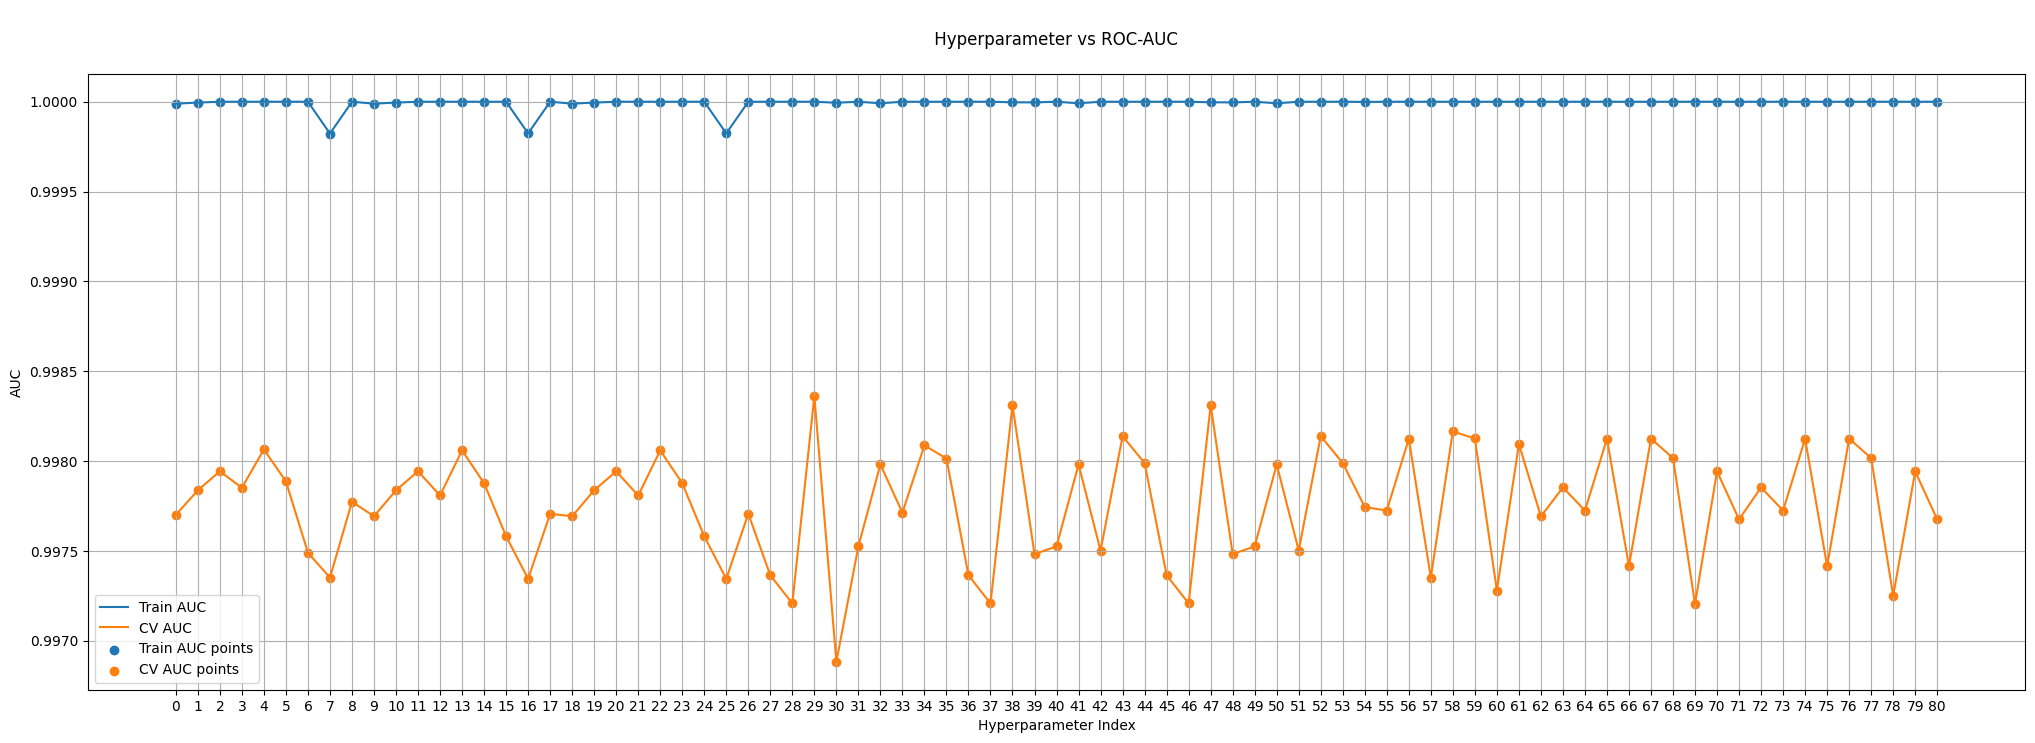

In [37]:
plt.figure(figsize=(25,8))
hyperparam_vs_auc(train_roc_auc, cv_roc_auc)

In [38]:
best_params = list(results.keys())[12]

In [39]:
print("The Best Paramaters are {} ".format(best_params))

The Best Paramaters are learning_rate : 0.02 max_depth : 12 subsample : 0.8 colsample_bytree : 0.6 


In [40]:
def tpr_fpr_threshold_auc(Y, proba):

    '''
        Utility Function to return fpr, tpr, threshold and roc_auc.
    '''

    fpr, tpr, threshold = sklearn.metrics.roc_curve(Y, proba)
    roc_auc = metrics.auc(fpr, tpr)

    return (fpr, tpr, threshold, roc_auc)

In [41]:
def train_cv_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc):

    '''
        Utility Function to Draw ROC-AUC Curves for Train and Validation Datasets.
    '''

    plt.title('\nReceiver Operating Characteristic\n')
    plt.plot(train_fpr, train_tpr, label = 'Train AUC = %0.2f' % train_roc_auc)
    plt.plot(cv_fpr, cv_tpr, label = 'CV AUC = %0.2f' % cv_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.show()

In [42]:
def best_threshold(threshold,tpr,fpr):

    '''
        Utility Function to return the best threshold value based on the TPR and FPR values.
    '''

    return threshold[np.argmax(tpr*(1-fpr))];


def class_label(best_thr, pred_score):

    '''
        Utility Function to return the class label based on the chosen threshold.
    '''
    return np.where(pred_score>best_thr,1,0);

In [43]:
def draw_confusion_matrix(Y, predicted):

    '''
        Utility Function to draw Confusion Matrix.
    '''

    cv_cm = metrics.confusion_matrix(Y, predicted)
    sns.heatmap(cv_cm, annot=True,fmt="d",cmap='Oranges', xticklabels=['Legit', 'Fraudulent'], yticklabels=['Legit', 'Fraudulent'])
    plt.title('\nConfusion  Matrix\n')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.show()

### Tuned Prediction

In [44]:
X = data.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = data['isFraud']

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.20, shuffle=False)
del X, y

In [45]:
print("*"*45)
print("\n Train Data Shape : {} \n".format(X_train.shape))
print("\n Cross Validation Data Shape : {} \n".format(X_cv.shape))
print("*"*45)

*********************************************

 Train Data Shape : (11397, 9) 


 Cross Validation Data Shape : (2850, 9) 

*********************************************


In [46]:
# Import necessary library
import xgboost as xgb

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_cv, label=y_cv)

# Set parameters for XGBoost
param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist',
    'random_state': 3,
    'subsample': 0.8,
    'max_depth': 12,
    'colsample_bytree': 0.6,
    'learning_rate': 0.02
}

# Train the model with early stopping
num_round = 3000
early_stopping_rounds = 100
watchlist = [(dtrain, 'train'), (dval, 'eval')]
results = xgb.train(param, dtrain, num_round, evals=watchlist,
                    early_stopping_rounds=early_stopping_rounds, verbose_eval=50)

# Access the trained model
clf = results

[0]	train-auc:0.94737	eval-auc:0.92742
[50]	train-auc:0.99938	eval-auc:0.99508


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99981	eval-auc:0.99660
[117]	train-auc:0.99987	eval-auc:0.99719


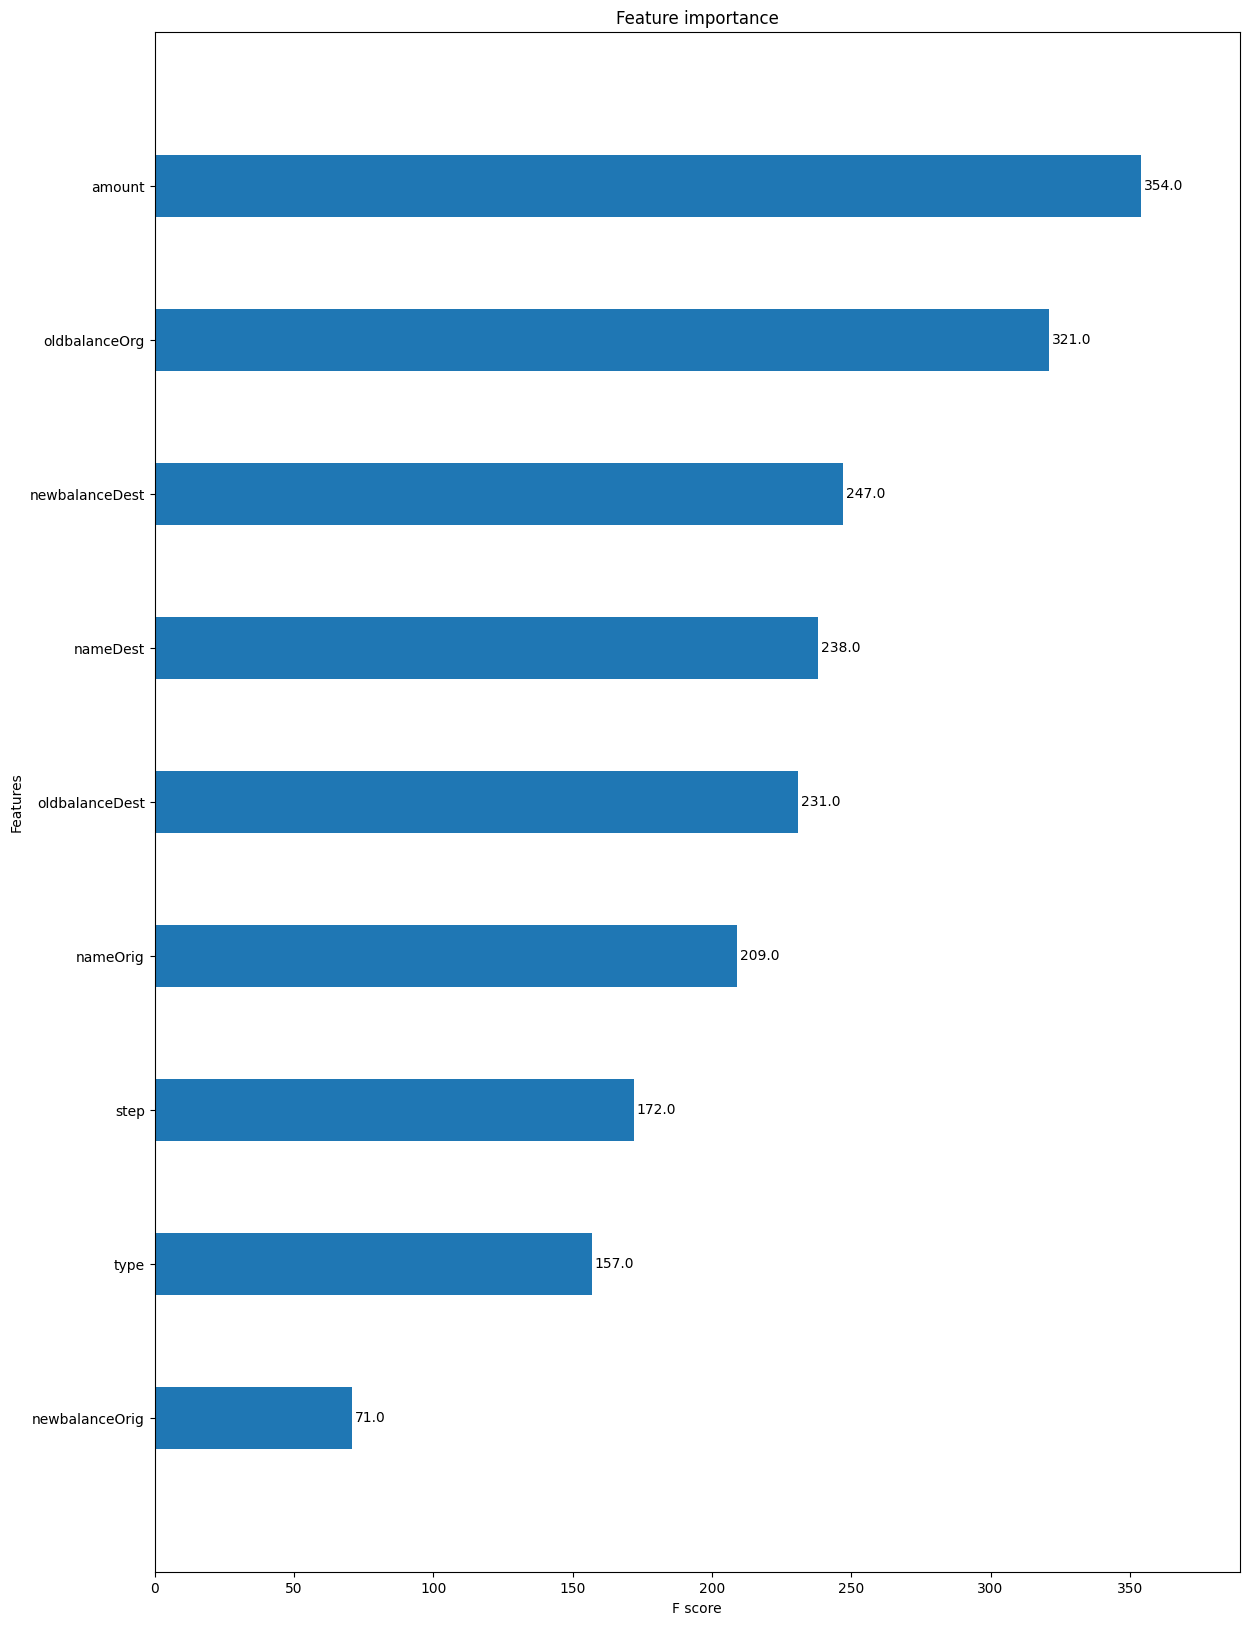

In [47]:
plt.rcParams["figure.figsize"] = (14, 20)
xgb.plot_importance(clf,max_num_features=50, grid=False, height=0.4)
plt.show()

In [48]:
# Import necessary library
import xgboost as xgb

# ... (Your existing code)

# Predict probabilities using DMatrix
dtrain_pred = xgb.DMatrix(X_train)
dcv_pred = xgb.DMatrix(X_cv)
dtest_pred = xgb.DMatrix(X_test)

train_proba = clf.predict(dtrain_pred)
cv_proba = clf.predict(dcv_pred)
test_proba = clf.predict(dtest_pred)

In [49]:

train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, train_proba)
cv_fpr, cv_tpr, cv_threshold, cv_roc_auc = tpr_fpr_threshold_auc(y_cv, cv_proba)

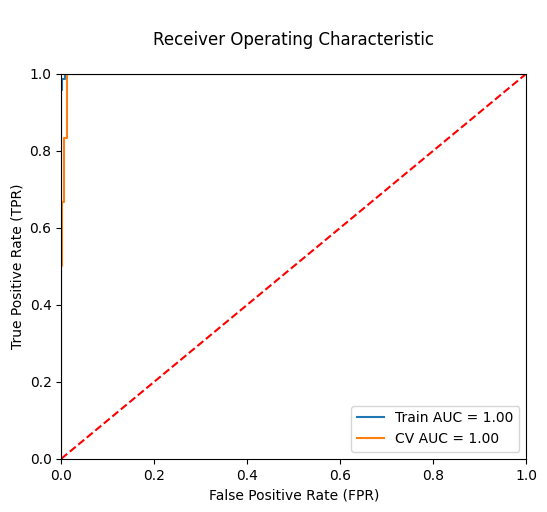

In [50]:
plt.rcParams["figure.figsize"] = (6, 5)
train_cv_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc)

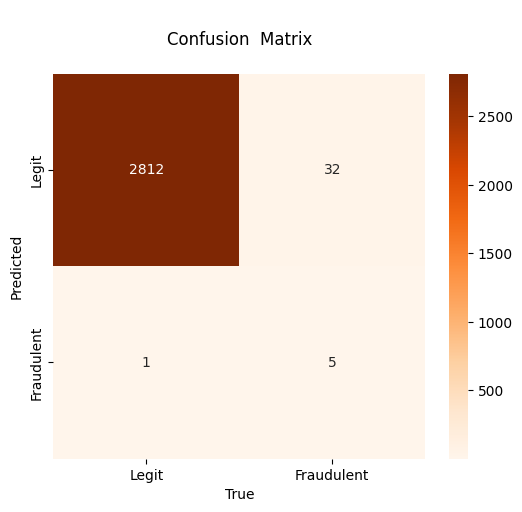

In [51]:
best_thr = best_threshold(cv_threshold, cv_tpr, cv_fpr)
cv_pred = class_label(best_thr, cv_proba)

draw_confusion_matrix(y_cv, cv_pred)

## Feature Engineering

In [52]:
def compute_vif(df, features):
    data = df[features]
    vif = {column:variance_inflation_factor(data.values, idx) for idx, column in enumerate(features)}
    return vif

In [53]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(df, features):
    data = df[features]
    # Handle infinite values
    data = data.replace([np.inf, -np.inf], np.nan)
    # Fill or drop missing values
    data = data.dropna()  # Or use data.fillna(some_value)
    vif = {column:variance_inflation_factor(data.values, idx) for idx, column in enumerate(features)}
    return vif

# Define the features you want to analyze
features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig'] # Replace with your actual column names

# Now call the function
vif = compute_vif(df, features)
print(vif)

{'step': 1.2353794277609909, 'amount': 1.3412841630015238, 'oldbalanceOrg': 203.50174756889572, 'newbalanceOrig': 202.16968227287018}


In [54]:
vif

{'step': 1.2353794277609909,
 'amount': 1.3412841630015238,
 'oldbalanceOrg': 203.50174756889572,
 'newbalanceOrig': 202.16968227287018}

In [55]:
def cat_num_features(df):

    '''
        Utility Function to get the names of Categorical Features and
        Numerical Features of the given Dataset.
    '''

    catf = []
    numf = []


    catf = ['type','nameOrig', 'isFraud'
            ,'nameDest','isFlaggedFraud']



    catf = [feature for feature in catf if feature in df.columns.values]
    numf = [feature for feature in df.columns if feature not in catf and not feature == 'isFraud']

    return (catf, numf)

In [56]:
def covariate_shift(df, feature, catf):

    '''
        Utility Function to compute Covariate Shift for given Feature in a Dataset.
    '''

    data = df.copy()
    data = label_encode(data, catf)

    X_train, X_test, y_train, y_test = train_test_split(data[feature], data['isFraud'], test_size=0.33,
                                                        random_state=3, stratify=data['isFraud'])
    clf = XGBClassifier(
      objective='binary:logistic',
      eval_metric='auc',
      n_estimators=500,
      tree_method='gpu_hist',
      random_state=3,
    )

    clf.fit(X_train.values.reshape(-1,1), y_train.values, verbose=1)

    roc_auc =  roc_auc_score(y_test.values, clf.predict_proba(X_test.values.reshape(-1,1))[:, 1])

    del X_train, y_train, X_test, y_test

    return roc_auc

In [57]:
def adversarial_validation(df, catf):
    list_auc_value = []

    cols = list(df.columns)
    cols.remove('isFraud')

    for f in cols:

        auc = covariate_shift(df, f, catf)
        list_auc_value.append(auc)
        print('*'*45)
        print('feature:', f, 'covariate shift:', auc)
        print('*'*45)

    cov = pd.Series(list_auc_value, index = cols).sort_values()

    return cov

In [58]:
catf, numf = cat_num_features(df)

In [59]:
def covariate_shift(df, feature, catf):

    '''
        Utility Function to compute Covariate Shift for given Feature in a Dataset.
    '''

    data = df.copy()
    data = label_encode(data, catf)  # Assuming 'label_encode' is defined elsewhere

    # Handle potential issue with stratification
    if len(data['isFraud'].unique()) < 2:
        print

In [60]:
new_type = {'PAYMENT':'OTHERS', 'TRANSFER':'TRANSFER', 'CASH_OUT':'CASH_OUT', 'DEBIT':'OTHERS', 'CASH_IN':'OTHERS'}
df['type']=df['type'].map(new_type)
df['type'].unique()

array(['OTHERS', 'TRANSFER', 'CASH_OUT'], dtype=object)

In [61]:
df['type2'] = np.nan
df.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('C'), 'type2'] = 'CC'
df.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('M'), 'type2'] = 'CM'
df.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('C'), 'type2'] = 'MC'
df.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('C'), 'type2'] = 'MM'

<ipython-input-61-dff961c32017>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'CC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('C'), 'type2'] = 'CC'


In [62]:
df.drop(columns = ['nameOrig','nameDest','step'], axis = 'columns', inplace = True)

In [63]:
df = pd.get_dummies(df, prefix = ['type', 'type2'], drop_first = False)

In [64]:
# Check for missing values in 'isFraud' column
print(df['isFraud'].isnull().sum())

# Handle missing values (e.g., drop rows with missing values)
df.dropna(subset=['isFraud'], inplace=True)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['isFraud','isFlaggedFraud'], axis=1),
    df['isFraud'],
    test_size=0.33,
    random_state=42,
    stratify=df['isFraud']
)

1


## Final Hyperparameter Tuning

In [65]:
learning_rate = [2e-2, 3e-1, 1e-1]
max_depth = [8, 12, 16]
subsample = [0.6,0.8,1]
colsample_bytree = [0.6,0.8,1]

In [66]:
results = {}

dtrain = xgb.DMatrix(X_train, label=y_train)

for rate in learning_rate:
  for depth in max_depth:
    for sample in subsample:
      for colsample in colsample_bytree:

        params = {
          'objective' : 'binary:logistic',
          'eval_metric' : 'auc',
          'learning_rate' : rate,
          'max_depth' : depth,
          'subsample' : sample,
          'colsample_bytree' : colsample,
          'tree_method' : 'gpu_hist',
          'random_state' : 3,
        }

        history = xgb.cv(
            params,
            dtrain,
            num_boost_round = 3000,
            nfold = 3,
            metrics ='auc',
            early_stopping_rounds = 100,
            verbose_eval=100,
            seed=3,
            shuffle = False
        )

        name = "learning_rate : "+str(rate)+" max_depth : "+str(depth)+" subsample : "+str(sample)+" colsample_bytree : "+str(colsample)
        results[name] = (history.iloc[-1]['train-auc-mean'],history.iloc[-1]['test-auc-mean'])

[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:28:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99928+0.00054	test-auc:0.99316+0.00551
[200]	train-auc:0.99974+0.00020	test-auc:0.99395+0.00579
[300]	train-auc:0.99990+0.00006	test-auc:0.99519+0.00458
[400]	train-auc:0.99995+0.00003	test-auc:0.99572+0.00365
[500]	train-auc:0.99998+0.00002	test-auc:0.99598+0.00288
[577]	train-auc:0.99999+0.00001	test-auc:0.99603+0.00276
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99953+0.00019	test-auc:0.99345+0.00560
[200]	train-auc:0.99983+0.00008	test-auc:0.99488+0.00462
[300]	train-auc:0.99993+0.00005	test-auc:0.99553+0.00368
[400]	train-auc:0.99996+0.00003	test-auc:0.99599+0.00274
[500]	train-auc:0.99998+0.00001	test-auc:0.99612+0.00239
[582]	train-auc:0.99998+0.00001	test-auc:0.99598+0.00242
[0]	train-auc:0.98705+0.00142	test-auc:0.96928+0.00340


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99932+0.00042	test-auc:0.99202+0.00448
[200]	train-auc:0.99989+0.00005	test-auc:0.99509+0.00418
[300]	train-auc:0.99995+0.00003	test-auc:0.99584+0.00298
[400]	train-auc:0.99998+0.00002	test-auc:0.99620+0.00232
[463]	train-auc:0.99998+0.00001	test-auc:0.99621+0.00222
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99966+0.00024	test-auc:0.99375+0.00552
[200]	train-auc:0.99989+0.00007	test-auc:0.99455+0.00529
[300]	train-auc:0.99998+0.00001	test-auc:0.99504+0.00490
[400]	train-auc:0.99999+0.00001	test-auc:0.99594+0.00355
[500]	train-auc:1.00000+0.00000	test-auc:0.99622+0.00287
[594]	train-auc:1.00000+0.00000	test-auc:0.99612+0.00278
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99975+0.00015	test-auc:0.99458+0.00440
[200]	train-auc:0.99994+0.00002	test-auc:0.99502+0.00451
[300]	train-auc:0.99998+0.00001	test-auc:0.99557+0.00360
[400]	train-auc:0.99999+0.00001	test-auc:0.99627+0.00239
[500]	train-auc:1.00000+0.00000	test-auc:0.99635+0.00203
[550]	train-auc:1.00000+0.00000	test-auc:0.99632+0.00210
[0]	train-auc:0.98967+0.00266	test-auc:0.97485+0.01558


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99961+0.00019	test-auc:0.99297+0.00413
[200]	train-auc:0.99994+0.00003	test-auc:0.99446+0.00493
[300]	train-auc:0.99998+0.00001	test-auc:0.99509+0.00383
[400]	train-auc:0.99999+0.00001	test-auc:0.99613+0.00227
[500]	train-auc:1.00000+0.00000	test-auc:0.99606+0.00218
[530]	train-auc:1.00000+0.00000	test-auc:0.99598+0.00222
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99983+0.00011	test-auc:0.99429+0.00554
[200]	train-auc:0.99996+0.00002	test-auc:0.99433+0.00558
[300]	train-auc:0.99999+0.00000	test-auc:0.99534+0.00445
[400]	train-auc:1.00000+0.00000	test-auc:0.99613+0.00317
[500]	train-auc:1.00000+0.00000	test-auc:0.99641+0.00250
[568]	train-auc:1.00000+0.00000	test-auc:0.99630+0.00247
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99983+0.00011	test-auc:0.99419+0.00522
[137]	train-auc:0.99991+0.00004	test-auc:0.99455+0.00521
[0]	train-auc:0.98527+0.01093	test-auc:0.97988+0.01459


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99968+0.00014	test-auc:0.98992+0.00791
[200]	train-auc:0.99995+0.00003	test-auc:0.99373+0.00557
[300]	train-auc:0.99998+0.00001	test-auc:0.99443+0.00416
[400]	train-auc:1.00000+0.00000	test-auc:0.99534+0.00306
[500]	train-auc:1.00000+0.00000	test-auc:0.99580+0.00244
[548]	train-auc:1.00000+0.00000	test-auc:0.99571+0.00258
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99928+0.00054	test-auc:0.99317+0.00551
[200]	train-auc:0.99974+0.00020	test-auc:0.99395+0.00579
[300]	train-auc:0.99990+0.00006	test-auc:0.99519+0.00458
[400]	train-auc:0.99995+0.00003	test-auc:0.99572+0.00365
[500]	train-auc:0.99998+0.00002	test-auc:0.99598+0.00287
[578]	train-auc:0.99999+0.00001	test-auc:0.99601+0.00275
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99953+0.00019	test-auc:0.99345+0.00560
[200]	train-auc:0.99983+0.00008	test-auc:0.99488+0.00462
[300]	train-auc:0.99993+0.00005	test-auc:0.99553+0.00368
[400]	train-auc:0.99996+0.00003	test-auc:0.99599+0.00274
[500]	train-auc:0.99998+0.00001	test-auc:0.99612+0.00239
[582]	train-auc:0.99998+0.00001	test-auc:0.99598+0.00242
[0]	train-auc:0.98705+0.00142	test-auc:0.96928+0.00340


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99932+0.00042	test-auc:0.99202+0.00448
[200]	train-auc:0.99989+0.00005	test-auc:0.99509+0.00418
[300]	train-auc:0.99995+0.00003	test-auc:0.99584+0.00298
[400]	train-auc:0.99998+0.00002	test-auc:0.99620+0.00232
[462]	train-auc:0.99998+0.00001	test-auc:0.99618+0.00226
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99966+0.00024	test-auc:0.99375+0.00552
[200]	train-auc:0.99989+0.00007	test-auc:0.99463+0.00520
[300]	train-auc:0.99998+0.00001	test-auc:0.99508+0.00482
[400]	train-auc:0.99999+0.00000	test-auc:0.99597+0.00343
[500]	train-auc:1.00000+0.00000	test-auc:0.99625+0.00279
[600]	train-auc:1.00000+0.00000	test-auc:0.99614+0.00268
[603]	train-auc:1.00000+0.00000	test-auc:0.99612+0.00271
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99975+0.00015	test-auc:0.99458+0.00440
[200]	train-auc:0.99994+0.00002	test-auc:0.99507+0.00440
[300]	train-auc:0.99998+0.00001	test-auc:0.99554+0.00366
[400]	train-auc:0.99999+0.00001	test-auc:0.99624+0.00241
[500]	train-auc:1.00000+0.00000	test-auc:0.99635+0.00202
[554]	train-auc:1.00000+0.00000	test-auc:0.99629+0.00211
[0]	train-auc:0.98967+0.00266	test-auc:0.97485+0.01558


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:29:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99961+0.00019	test-auc:0.99297+0.00413
[200]	train-auc:0.99994+0.00003	test-auc:0.99446+0.00493
[300]	train-auc:0.99998+0.00001	test-auc:0.99508+0.00382
[400]	train-auc:0.99999+0.00001	test-auc:0.99614+0.00227
[500]	train-auc:1.00000+0.00000	test-auc:0.99607+0.00219
[530]	train-auc:1.00000+0.00000	test-auc:0.99603+0.00224
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99983+0.00011	test-auc:0.99415+0.00573
[200]	train-auc:0.99996+0.00002	test-auc:0.99437+0.00555
[300]	train-auc:0.99999+0.00000	test-auc:0.99533+0.00448
[400]	train-auc:1.00000+0.00000	test-auc:0.99606+0.00332
[500]	train-auc:1.00000+0.00000	test-auc:0.99638+0.00258
[568]	train-auc:1.00000+0.00000	test-auc:0.99627+0.00263
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99983+0.00011	test-auc:0.99419+0.00522
[138]	train-auc:0.99991+0.00004	test-auc:0.99410+0.00583
[0]	train-auc:0.98527+0.01093	test-auc:0.97988+0.01459


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99968+0.00014	test-auc:0.98992+0.00791
[200]	train-auc:0.99996+0.00003	test-auc:0.99373+0.00556
[300]	train-auc:0.99998+0.00001	test-auc:0.99443+0.00416
[400]	train-auc:1.00000+0.00000	test-auc:0.99525+0.00319
[500]	train-auc:1.00000+0.00000	test-auc:0.99586+0.00236
[600]	train-auc:1.00000+0.00000	test-auc:0.99579+0.00241
[607]	train-auc:1.00000+0.00000	test-auc:0.99578+0.00244
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99928+0.00054	test-auc:0.99317+0.00551
[200]	train-auc:0.99974+0.00020	test-auc:0.99395+0.00579
[300]	train-auc:0.99990+0.00006	test-auc:0.99519+0.00458
[400]	train-auc:0.99995+0.00003	test-auc:0.99572+0.00365
[500]	train-auc:0.99998+0.00002	test-auc:0.99598+0.00287
[578]	train-auc:0.99999+0.00001	test-auc:0.99601+0.00275
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99953+0.00019	test-auc:0.99345+0.00560
[200]	train-auc:0.99983+0.00008	test-auc:0.99488+0.00462
[300]	train-auc:0.99993+0.00005	test-auc:0.99553+0.00368
[400]	train-auc:0.99996+0.00003	test-auc:0.99599+0.00274
[500]	train-auc:0.99998+0.00001	test-auc:0.99612+0.00239
[582]	train-auc:0.99998+0.00001	test-auc:0.99598+0.00242
[0]	train-auc:0.98705+0.00142	test-auc:0.96928+0.00340


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99932+0.00042	test-auc:0.99202+0.00448
[200]	train-auc:0.99989+0.00005	test-auc:0.99509+0.00418
[300]	train-auc:0.99995+0.00003	test-auc:0.99584+0.00298
[400]	train-auc:0.99998+0.00002	test-auc:0.99620+0.00232
[463]	train-auc:0.99998+0.00001	test-auc:0.99621+0.00222
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99966+0.00024	test-auc:0.99375+0.00552
[200]	train-auc:0.99989+0.00007	test-auc:0.99463+0.00520
[300]	train-auc:0.99998+0.00001	test-auc:0.99508+0.00482
[400]	train-auc:0.99999+0.00000	test-auc:0.99597+0.00343
[500]	train-auc:1.00000+0.00000	test-auc:0.99625+0.00279
[600]	train-auc:1.00000+0.00000	test-auc:0.99614+0.00268
[603]	train-auc:1.00000+0.00000	test-auc:0.99612+0.00271
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99975+0.00015	test-auc:0.99458+0.00440
[200]	train-auc:0.99994+0.00002	test-auc:0.99507+0.00440
[300]	train-auc:0.99998+0.00001	test-auc:0.99554+0.00366
[400]	train-auc:0.99999+0.00001	test-auc:0.99624+0.00241
[500]	train-auc:1.00000+0.00000	test-auc:0.99635+0.00202
[554]	train-auc:1.00000+0.00000	test-auc:0.99629+0.00211
[0]	train-auc:0.98967+0.00266	test-auc:0.97485+0.01558


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99961+0.00019	test-auc:0.99297+0.00413
[200]	train-auc:0.99994+0.00003	test-auc:0.99446+0.00493
[300]	train-auc:0.99998+0.00001	test-auc:0.99508+0.00382
[400]	train-auc:0.99999+0.00001	test-auc:0.99614+0.00227
[500]	train-auc:1.00000+0.00000	test-auc:0.99607+0.00219
[530]	train-auc:1.00000+0.00000	test-auc:0.99603+0.00224
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99983+0.00011	test-auc:0.99415+0.00573
[200]	train-auc:0.99996+0.00002	test-auc:0.99437+0.00555
[300]	train-auc:0.99999+0.00000	test-auc:0.99533+0.00448
[400]	train-auc:1.00000+0.00000	test-auc:0.99606+0.00332
[500]	train-auc:1.00000+0.00000	test-auc:0.99638+0.00258
[569]	train-auc:1.00000+0.00000	test-auc:0.99625+0.00263
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99983+0.00011	test-auc:0.99419+0.00522
[138]	train-auc:0.99991+0.00004	test-auc:0.99410+0.00583
[0]	train-auc:0.98527+0.01093	test-auc:0.97988+0.01459


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99968+0.00014	test-auc:0.98992+0.00791
[200]	train-auc:0.99996+0.00003	test-auc:0.99373+0.00556
[300]	train-auc:0.99998+0.00001	test-auc:0.99443+0.00416
[400]	train-auc:1.00000+0.00000	test-auc:0.99525+0.00319
[500]	train-auc:1.00000+0.00000	test-auc:0.99586+0.00236
[600]	train-auc:1.00000+0.00000	test-auc:0.99579+0.00241
[606]	train-auc:1.00000+0.00000	test-auc:0.99578+0.00242
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99999+0.00000	test-auc:0.99347+0.00456
[130]	train-auc:1.00000+0.00000	test-auc:0.98893+0.01058
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99459+0.00421
[129]	train-auc:1.00000+0.00000	test-auc:0.99451+0.00421
[0]	train-auc:0.98705+0.00142	test-auc:0.96928+0.00340
[100]	train-auc:1.00000+0.00000	test-auc:0.99450+0.00361
[130]	train-auc:1.00000+0.00000	test-auc:0.99433+0.00365
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99535+0.00314
[154]	train-auc:1.00000+0.00000	test-auc:0.99464+0.00400
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99511+0.00340
[128]	train-auc:1.00000+0.00000	test-auc:0.99548+0.00291
[0]	train-auc:0.98967+0.00266	test-auc:0.97485+0.01558


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99562+0.00256
[120]	train-auc:1.00000+0.00000	test-auc:0.99485+0.00343
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394
[100]	train-auc:1.00000+0.00000	test-auc:0.99484+0.00330
[131]	train-auc:1.00000+0.00000	test-auc:0.99453+0.00360
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99550+0.00216
[126]	train-auc:1.00000+0.00000	test-auc:0.99541+0.00216
[0]	train-auc:0.98527+0.01093	test-auc:0.97988+0.01459


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99501+0.00263
[132]	train-auc:1.00000+0.00000	test-auc:0.99493+0.00256
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99999+0.00000	test-auc:0.99408+0.00491
[130]	train-auc:1.00000+0.00000	test-auc:0.98954+0.01095
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99459+0.00421
[129]	train-auc:1.00000+0.00000	test-auc:0.99451+0.00421
[0]	train-auc:0.98705+0.00142	test-auc:0.96928+0.00340


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99450+0.00361
[131]	train-auc:1.00000+0.00000	test-auc:0.99298+0.00557
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665
[100]	train-auc:1.00000+0.00000	test-auc:0.99535+0.00314
[155]	train-auc:1.00000+0.00000	test-auc:0.99467+0.00405
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99511+0.00340
[128]	train-auc:1.00000+0.00000	test-auc:0.99548+0.00291
[0]	train-auc:0.98967+0.00266	test-auc:0.97485+0.01558


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99562+0.00256
[120]	train-auc:1.00000+0.00000	test-auc:0.99485+0.00343
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99484+0.00330
[131]	train-auc:1.00000+0.00000	test-auc:0.99453+0.00360
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394
[100]	train-auc:1.00000+0.00000	test-auc:0.99550+0.00216
[127]	train-auc:1.00000+0.00000	test-auc:0.99542+0.00217
[0]	train-auc:0.98527+0.01093	test-auc:0.97988+0.01459


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99492+0.00274
[134]	train-auc:1.00000+0.00000	test-auc:0.99480+0.00274
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99999+0.00000	test-auc:0.99408+0.00491
[130]	train-auc:1.00000+0.00000	test-auc:0.98954+0.01095
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99459+0.00421
[128]	train-auc:1.00000+0.00000	test-auc:0.99369+0.00542
[0]	train-auc:0.98705+0.00142	test-auc:0.96928+0.00340
[100]	train-auc:1.00000+0.00000	test-auc:0.99450+0.00361
[131]	train-auc:1.00000+0.00000	test-auc:0.99298+0.00557
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99535+0.00314
[154]	train-auc:1.00000+0.00000	test-auc:0.99464+0.00400
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99511+0.00340
[128]	train-auc:1.00000+0.00000	test-auc:0.99548+0.00291
[0]	train-auc:0.98967+0.00266	test-auc:0.97485+0.01558


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99562+0.00256
[119]	train-auc:1.00000+0.00000	test-auc:0.99534+0.00278
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99484+0.00330
[130]	train-auc:1.00000+0.00000	test-auc:0.99450+0.00364
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:30:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99550+0.00216
[127]	train-auc:1.00000+0.00000	test-auc:0.99542+0.00217
[0]	train-auc:0.98527+0.01093	test-auc:0.97988+0.01459


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99492+0.00274
[133]	train-auc:1.00000+0.00000	test-auc:0.99482+0.00271
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397
[100]	train-auc:0.99997+0.00003	test-auc:0.99660+0.00174
[181]	train-auc:1.00000+0.00000	test-auc:0.99628+0.00175
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99997+0.00002	test-auc:0.99656+0.00210
[196]	train-auc:1.00000+0.00000	test-auc:0.99585+0.00238
[0]	train-auc:0.98705+0.00142	test-auc:0.96928+0.00340


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99998+0.00002	test-auc:0.99623+0.00206
[165]	train-auc:1.00000+0.00000	test-auc:0.99574+0.00221
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665
[100]	train-auc:1.00000+0.00000	test-auc:0.99583+0.00301
[200]	train-auc:1.00000+0.00000	test-auc:0.99589+0.00273
[240]	train-auc:1.00000+0.00000	test-auc:0.99582+0.00277
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99999+0.00000	test-auc:0.99644+0.00199
[194]	train-auc:1.00000+0.00000	test-auc:0.99601+0.00221
[0]	train-auc:0.98967+0.00266	test-auc:0.97485+0.01558


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00001	test-auc:0.99616+0.00189
[185]	train-auc:1.00000+0.00000	test-auc:0.99587+0.00211
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99616+0.00269
[199]	train-auc:1.00000+0.00000	test-auc:0.99537+0.00344
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99601+0.00257
[194]	train-auc:1.00000+0.00000	test-auc:0.99588+0.00256
[0]	train-auc:0.98527+0.01093	test-auc:0.97988+0.01459


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99587+0.00240
[200]	train-auc:1.00000+0.00000	test-auc:0.99594+0.00225
[231]	train-auc:1.00000+0.00000	test-auc:0.99590+0.00226
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99997+0.00003	test-auc:0.99660+0.00174
[180]	train-auc:1.00000+0.00000	test-auc:0.99622+0.00174
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99997+0.00002	test-auc:0.99656+0.00210
[197]	train-auc:1.00000+0.00000	test-auc:0.99590+0.00240
[0]	train-auc:0.98705+0.00142	test-auc:0.96928+0.00340


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99998+0.00002	test-auc:0.99623+0.00206
[165]	train-auc:1.00000+0.00000	test-auc:0.99574+0.00221
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99596+0.00283
[200]	train-auc:1.00000+0.00000	test-auc:0.99572+0.00297
[236]	train-auc:1.00000+0.00000	test-auc:0.99597+0.00257
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99999+0.00000	test-auc:0.99644+0.00199
[194]	train-auc:1.00000+0.00000	test-auc:0.99601+0.00221
[0]	train-auc:0.98967+0.00266	test-auc:0.97485+0.01558


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00001	test-auc:0.99616+0.00189
[185]	train-auc:1.00000+0.00000	test-auc:0.99587+0.00211
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99616+0.00269
[198]	train-auc:1.00000+0.00000	test-auc:0.99537+0.00344
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99601+0.00257
[194]	train-auc:1.00000+0.00000	test-auc:0.99588+0.00256
[0]	train-auc:0.98527+0.01093	test-auc:0.97988+0.01459


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99571+0.00262
[200]	train-auc:1.00000+0.00000	test-auc:0.99566+0.00264
[256]	train-auc:1.00000+0.00000	test-auc:0.99543+0.00282
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99997+0.00003	test-auc:0.99660+0.00174
[179]	train-auc:1.00000+0.00000	test-auc:0.99615+0.00183
[0]	train-auc:0.97304+0.00541	test-auc:0.96391+0.00397


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99997+0.00002	test-auc:0.99656+0.00210
[196]	train-auc:1.00000+0.00000	test-auc:0.99585+0.00238
[0]	train-auc:0.98705+0.00142	test-auc:0.96928+0.00340


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99998+0.00002	test-auc:0.99623+0.00206
[166]	train-auc:1.00000+0.00001	test-auc:0.99576+0.00218
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99596+0.00283
[200]	train-auc:1.00000+0.00000	test-auc:0.99572+0.00297
[237]	train-auc:1.00000+0.00000	test-auc:0.99597+0.00255
[0]	train-auc:0.98062+0.00959	test-auc:0.96654+0.01665


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:0.99999+0.00000	test-auc:0.99644+0.00199
[194]	train-auc:1.00000+0.00000	test-auc:0.99601+0.00221
[0]	train-auc:0.98967+0.00266	test-auc:0.97485+0.01558


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00001	test-auc:0.99616+0.00189
[184]	train-auc:1.00000+0.00000	test-auc:0.99587+0.00208
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99616+0.00269
[198]	train-auc:1.00000+0.00000	test-auc:0.99537+0.00344
[0]	train-auc:0.97841+0.00702	test-auc:0.96528+0.01394


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99601+0.00257
[194]	train-auc:1.00000+0.00000	test-auc:0.99588+0.00256
[0]	train-auc:0.98527+0.01093	test-auc:0.97988+0.01459


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[100]	train-auc:1.00000+0.00000	test-auc:0.99571+0.00262
[200]	train-auc:1.00000+0.00000	test-auc:0.99566+0.00264
[256]	train-auc:1.00000+0.00000	test-auc:0.99543+0.00282


In [67]:
train_roc_auc = [auc[0] for auc in results.values()]
cv_roc_auc = [auc[1] for auc in results.values()]

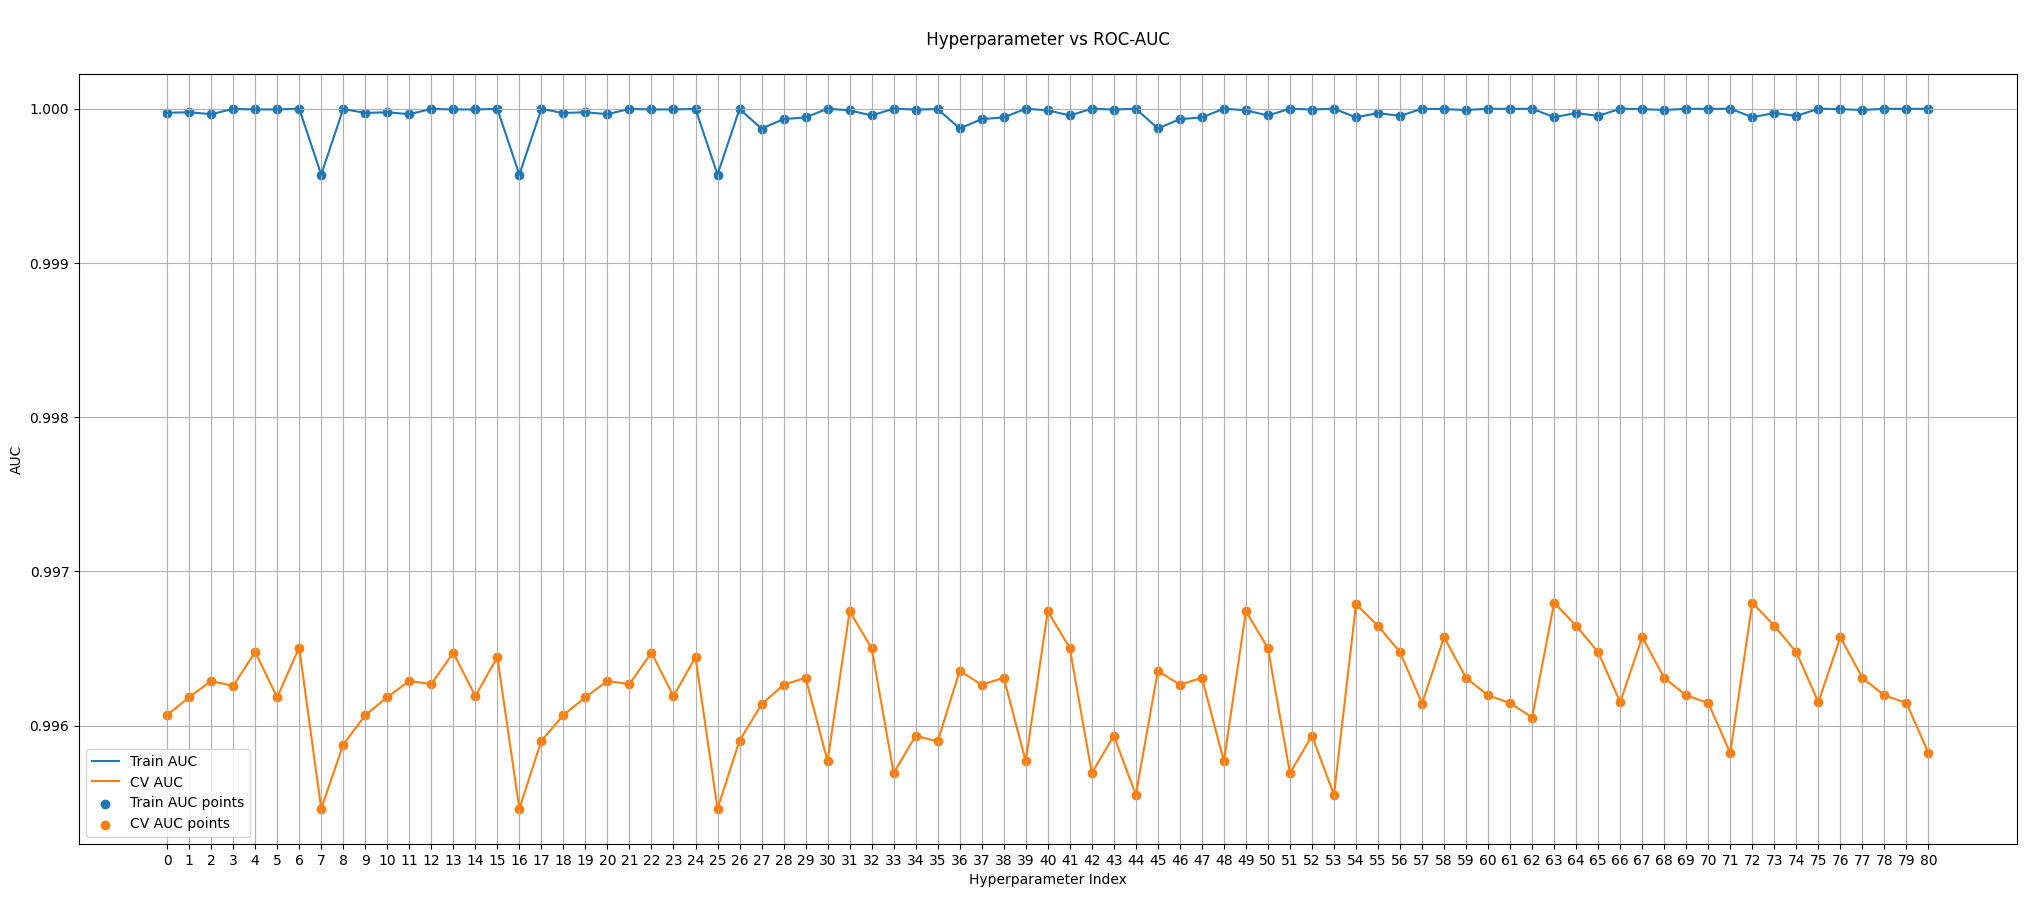

In [68]:
plt.figure(figsize=(25,10))
hyperparam_vs_auc(train_roc_auc, cv_roc_auc)

In [69]:
best_params = list(results.keys())[3]
print("The Best Paramaters are {} ".format(best_params))

The Best Paramaters are learning_rate : 0.02 max_depth : 8 subsample : 0.8 colsample_bytree : 0.6 


## Final Modeling

In [70]:
X = df.drop(['isFraud','isFlaggedFraud'], axis=1)
y = df['isFraud']

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.20, shuffle=False)
del X, y

In [71]:
clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=3000,
    tree_method='gpu_hist',
    random_state=3,
    subsample=0.8,
    max_depth=8,
    colsample_bytree=0.6,
    learning_rate=0.02
)

#

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


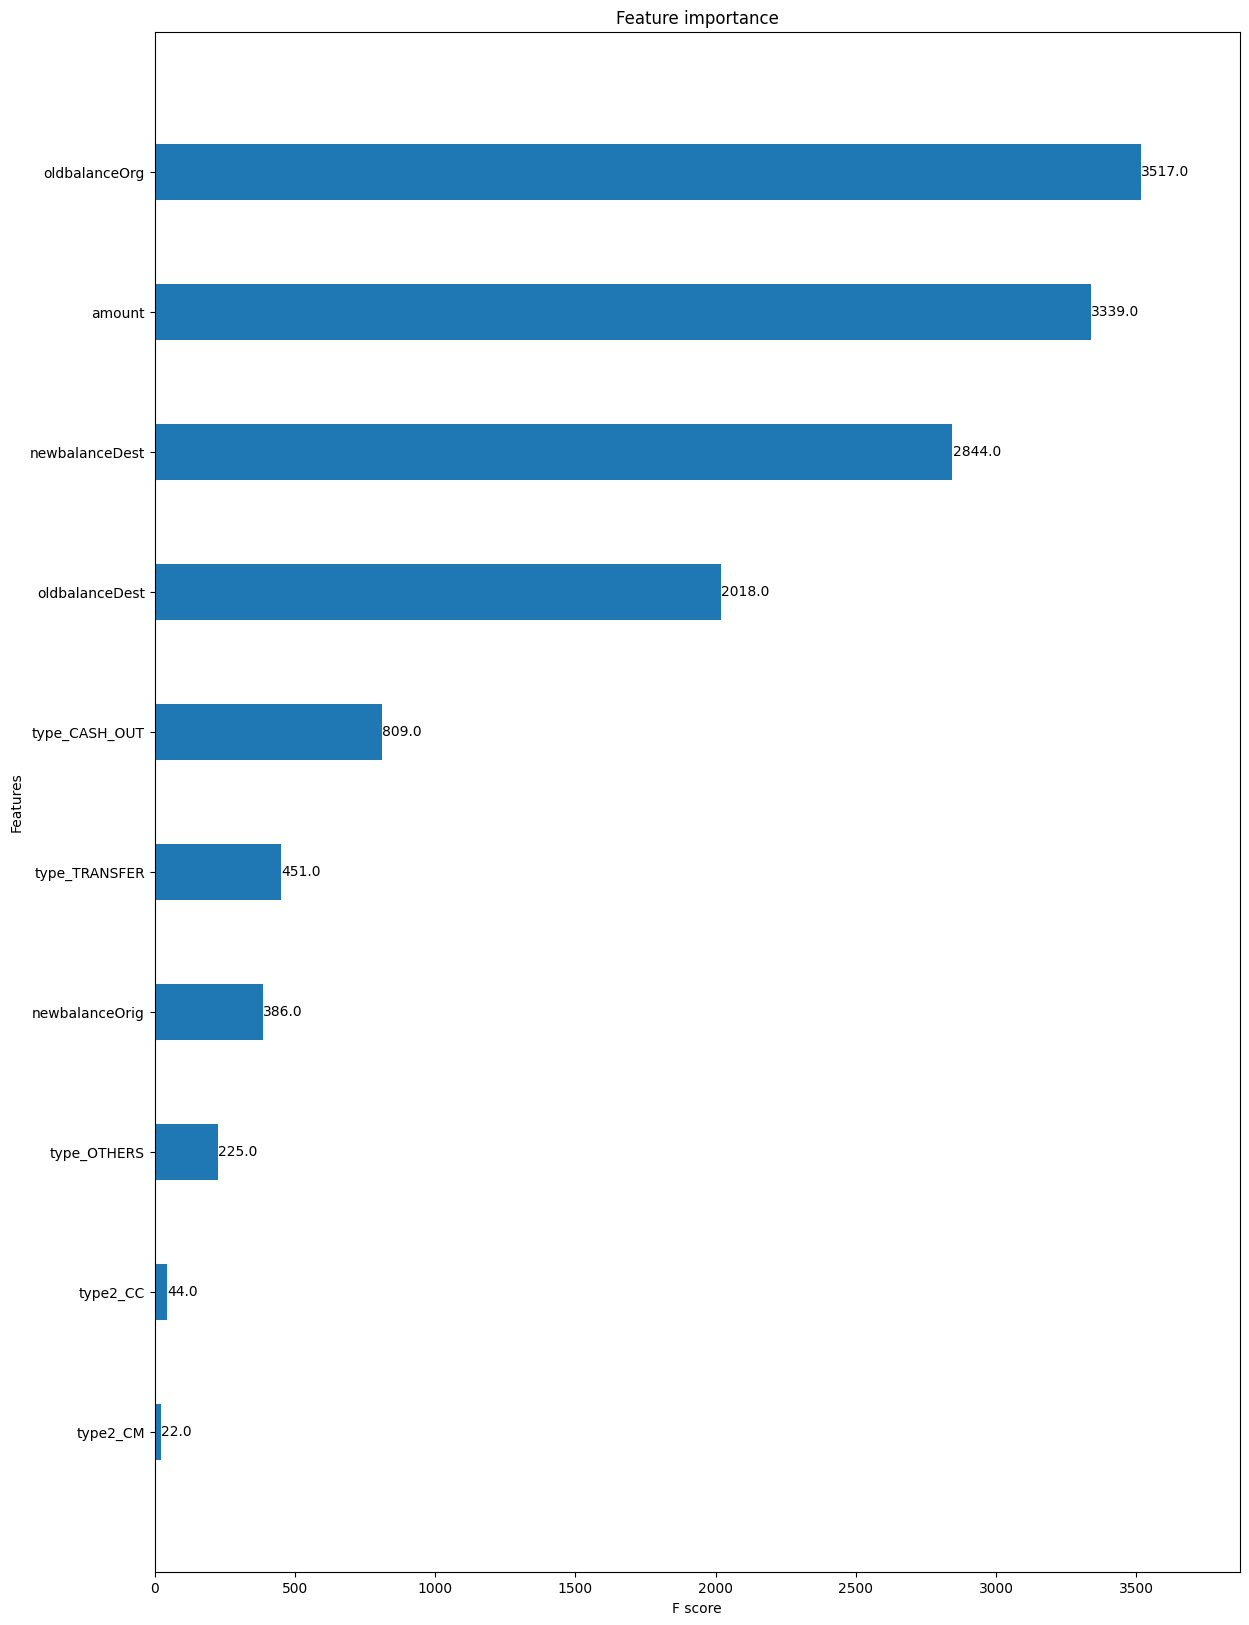

In [72]:
# Previous code to define and configure the classifier (unchanged)
clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=3000,
    tree_method='gpu_hist',
    random_state=3,
    subsample=0.8,
    max_depth=8,
    colsample_bytree=0.6,
    learning_rate=0.02
)

# Fit the model to your training data
clf.fit(X_train, y_train)

# Now you can plot the feature importances
plt.rcParams["figure.figsize"] = (14, 20)
xgb.plot_importance(clf,max_num_features=50, grid=False, height=0.4)
plt.show()

In [73]:
train_proba = clf.predict_proba(X_train)[:,1]
cv_proba = clf.predict_proba(X_cv)[:,1]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:31:38] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [74]:
train_fpr, train_tpr, train_threshold, train_roc_auc = tpr_fpr_threshold_auc(y_train, train_proba)
cv_fpr, cv_tpr, cv_threshold, cv_roc_auc = tpr_fpr_threshold_auc(y_cv, cv_proba)

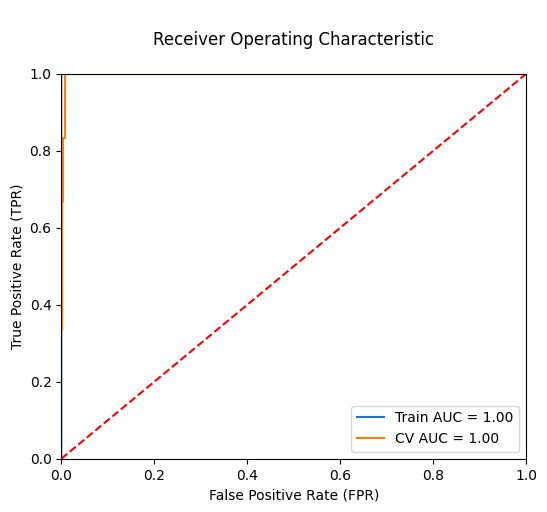

In [75]:
plt.rcParams["figure.figsize"] = (6, 5)
train_cv_auc(train_fpr, train_tpr, train_roc_auc, cv_fpr, cv_tpr, cv_roc_auc)

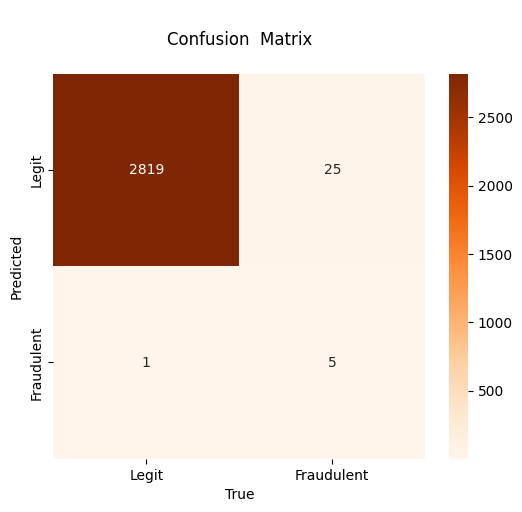

In [76]:
best_thr = best_threshold(cv_threshold, cv_tpr, cv_fpr)
cv_pred = class_label(best_thr, cv_proba)

draw_confusion_matrix(y_cv, cv_pred)